In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
from scipy.integrate import solve_ivp 
from numpy.random import MT19937, RandomState, SeedSequence
from matplotlib import animation

In [2]:
class KuramotoHemisphere(): 
    
    def __init__(self, epsilon, eta, sigma, mean_omega, grad=0):
        # Initialises the class with the model parameters 
        self.epsilon = epsilon 
        self.eta = eta 
        self.sigma = sigma
        self.mean_omega = mean_omega 
        self.BC = BC
        self.grad = grad  
        
    def initialise(self, N, T, n_frames, seed=None): 
        self.size = N
        self.T = T 
        self.n_frames = int(n_frames)
        self.initial_state = np.zeros((N))
        
        self._make_lattice()
        self._set_omegas(seed)
        
    def evolve(self): 
        
        t_eval = np.linspace(0, T-1, self.n_frames)
        coupling = np.empty(self.size)
        self.res = solve_ivp(self._rhs, [0, T], self.initial_state, method='LSODA', 
                          t_eval=t_eval, args=[coupling])
        
        
    def _rhs(self, t, theta, coupling): 
        
        for i in range(self.size): 
            nn = self.neighbours[self.locs[i]:self.locs[i+1]]
            d_thetas = theta[nn] - theta[i]
            coupling[i] = np.sum(self._coupling(d_thetas))
        rhs = self.epsilon*coupling + self.omegas
        
        return rhs
    
    def _coupling(self, d_theta): 
        return np.sin(d_theta) + self.eta*(1-np.cos(d_theta))
        
    def _make_lattice(self): 
        self.x, self.y, self.z = self._fibo_hemisphere() 
        self.tri = Delaunay(np.stack([self.x, self.y]).T)
        self.locs, self.neighbours = self.tri.vertex_neighbor_vertices
        self.boundary = [self.z == 0]
        
    def _fibo_hemisphere(self):
        ga = (3 - np.sqrt(5)) * np.pi # golden angle                                                                                                                        
        theta = ga * np.arange(self.size)                                                
        z = np.linspace(0, 1-1/self.size, self.size)
                                                       
        radius = np.sqrt(1 - z * z)                                          
        y = radius * np.sin(theta)
        x = radius * np.cos(theta)
        return x, y, z
        
    def _set_omegas(self, seed): 
        if seed is None:
            self.omegas = self.sigma*np.random.normal(size=(N)) + self.mean_omega
        else: 
            rs = RandomState(MT19937(SeedSequence(seed)))
            self.omegas = self.sigma*rs.normal(size=(N)) + self.mean_omega 

In [202]:
# Set up model parameters 
epsilon = 0.1
eta = 0 # asymmetry parameter
sigma = mean_omega*0.1 # disorder
mean_omega = 0.2
g = 0
BC = 'grad'

# Set up simulation parameters 
N = 200
T = 200
n_frames = T

# Set up a gradient 

seed = None

# Initialise the model and run the simulation 
model = KuramotoHemisphere(epsilon, eta, sigma, 0)
model.initialise(N, T, n_frames, seed=seed) 
model.omegas += mean_omega/(1-model.z/np.max(model.z)*0.03)
model.evolve() 

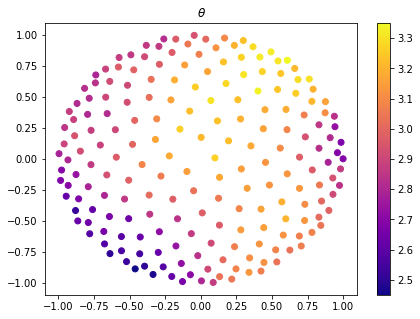

In [203]:
theta = model.res.y[:, -1] % (2*np.pi) 

plt.figure(figsize=(7, 5))
plt.scatter(model.x, model.y, c=theta, cmap='plasma')
plt.colorbar()
plt.title(r'$\theta$')
plt.show() 

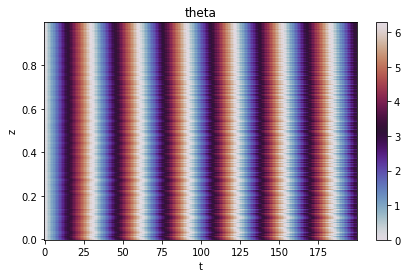

In [204]:
thetas = model.res.y % (2*np.pi)
z_array = model.z 
t_array = model.res.t

X, Y = np.meshgrid(t_array, z_array)
plt.figure(figsize=(7, 4))
plt.pcolor(X, Y, thetas, cmap='twilight')
plt.xlabel('t')
plt.ylabel('z')
plt.title('theta')
plt.colorbar()
plt.show() 

In [205]:
# Reshape the result into 2D shape 
N = 100 # number of frames to use in making the movie 

phase_evolution = model.res.y[:, ::int(n_frames/N)].T % (2*np.pi)
print(phase_evolution.shape)

# Set up figure plotting 
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

vmin = 0
vmax = 2*np.pi

p1 = ax.scatter(model.x, model.y, c=phase_evolution[0], vmin=vmin, vmax=vmax, cmap='twilight')
fig.colorbar(p1, ax=ax, shrink=0.8)
ax.axis('off')
panels = [p1]

def animate(i): 

    panels[0].set_array(phase_evolution[i])
    return panels

ani = animation.FuncAnimation(fig, animate, interval=50, blit=True,
                                repeat_delay=1000, frames=N)
plt.close() 

(100, 200)


In [206]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=2000)

ani.save('sim.mp4', writer=writer, dpi=200)